In [2]:
import pandas as pd
data = pd.read_csv('WA_Fn-UseC_-HR-Employee-Attrition.csv')
data.head(5)

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

In [4]:
data['Attrition'].value_counts()

Attrition
No     1233
Yes     237
Name: count, dtype: int64

In [12]:
# Convert categorical target variable into binary numeric. 
data["Attrition_Encoded"] = data["Attrition"].map({"Yes":1,"No":0})

attrition_rate = sum(data["Attrition_Encoded"])/len(data) * 100
print(f"Attrition_rate: {attrition_rate:.2f}%")

Attrition_rate: 16.12%


In [13]:
# let's try to localize the metric. 
dep_attr = data.groupby("Department")["Attrition_Encoded"].sum().sort_values(ascending=False)
dep_attr

Department
Research & Development    133
Sales                      92
Human Resources            12
Name: Attrition_Encoded, dtype: int64

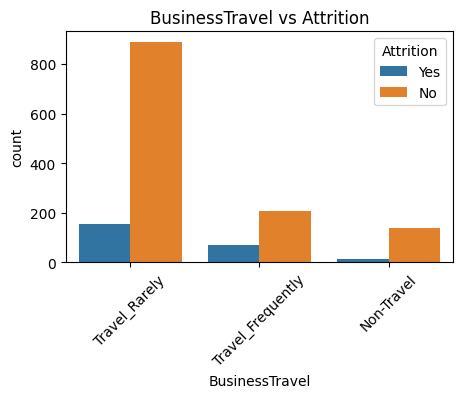

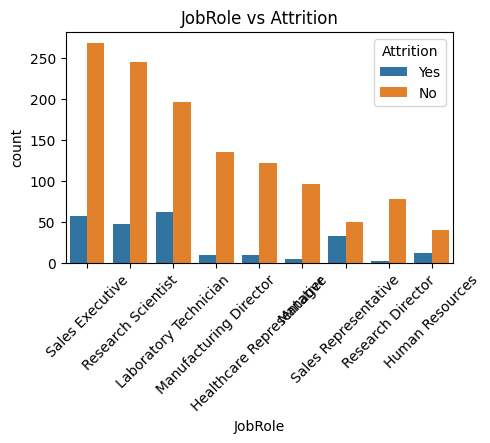

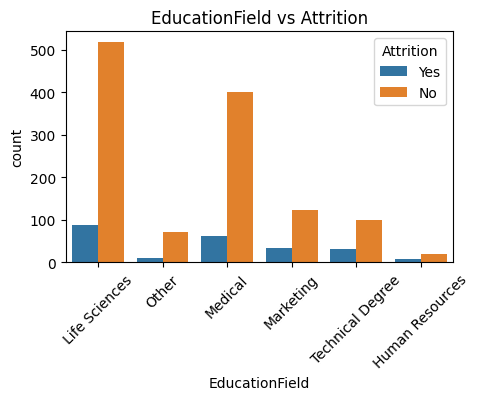

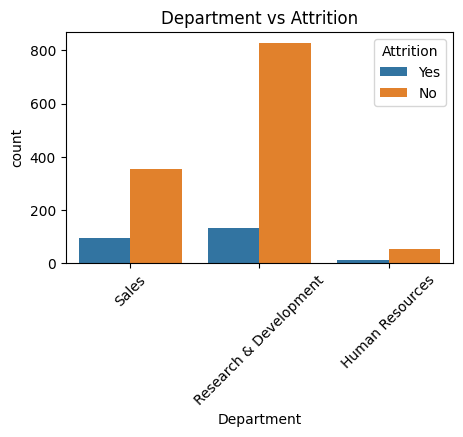

In [107]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

cat_cols = ['BusinessTravel', 'JobRole', 'EducationField', 'Department']

for col in cat_cols:
    plt.figure(figsize=(5,3))
    sns.countplot(x=col, hue='Attrition', data=data)
    plt.title(f'{col} vs Attrition')
    plt.xticks(rotation=45)
    plt.show()

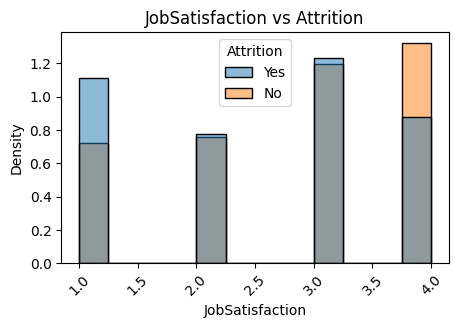

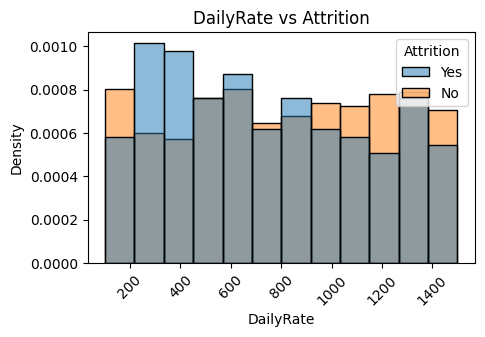

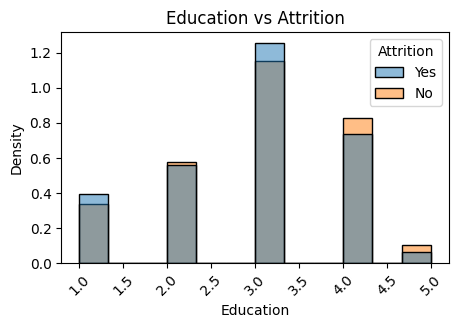

In [106]:
#cat_cols = ['Age', 'DistanceFromHome', 'StockOptionLevel', 'YearsAtCompany']
cat_cols = ['JobSatisfaction', 'DailyRate', 'Education']

for col in cat_cols:
    plt.figure(figsize=(5,3))
    #sns.countplot(x=col, hue='Attrition', data=data)
    sns.histplot(x=col, data=data, hue='Attrition', stat='density', common_norm=False)
    #sns.kdeplot(x=col, data=data, hue='Attrition', common_norm=False)
    plt.title(f'{col} vs Attrition')
    plt.xticks(rotation=45)
    plt.show()
    

In [82]:
# So after EDA we found a few factors that have impact on target ("Arrtition"), let's call them as factor-candidates. 
# Then we choose factors from them which company can actually change. 
# We want to chech hypothesis about the causal effect of a each factor (e.g., “frequent business trips → higher likelihood of leaving”).

# Method of evaluating effect: PSM (Propensity Score Matching)

# Question: ""Does 'BusinessTravel'{Travel_Rarely} affect the likelihood of employee attrition compared to 'Non-Travel' ?"
# Treatment & Control : ['Travel_Rarely','Non-Travel']
# covariates: ['Age', 'JobLevel', 'Education']
# Outcome :  'Attrition'

In [95]:

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors

def psm_estimation(df_binary, factor):
    # Step 1: propensity score
    X = df_binary[["Age", "MonthlyIncome", "Education"]]
    y = df_binary["treatment"]
    
    logit = LogisticRegression().fit(X, y)
    df_binary["propensity_score"] = logit.predict_proba(X)[:,1]
    
    # Step 2: Matching 
    treated = df_binary[df_binary["treatment"]==1]
    control = df_binary[df_binary["treatment"]==0]
    
    nn = NearestNeighbors(n_neighbors=1).fit(control[["propensity_score"]])
    distances, indices = nn.kneighbors(treated[["propensity_score"]])
    matched_control = control.iloc[indices.flatten()].copy()
    matched_treated = treated.reset_index(drop=True)
    
    matched = pd.concat([matched_treated, matched_control], axis=0)
    
    
    ate = matched[matched["treatment"]==1]["Attrition_Encoded"].mean() - matched[matched["treatment"]==0]["Attrition_Encoded"].mean()
    
    print("Estimating the effect (ATE) of '", factor, "' on attrition:", round(ate,3))


In [105]:
df_binary = data[data["BusinessTravel"].isin(["Non-Travel", "Travel_Rarely"])].copy()
df_binary["treatment"] = (df_binary["BusinessTravel"] == "Travel_Rarely").astype(int)
psm_estimation(df_binary, "Travel_Rarely business trips")

# So 'Travel_Rarely' business trips increase the likelihood of employee attrition compared to 'Non-Travel' in 6.8% 

Estimating the effect (ATE) of ' Travel_Rarely business trips ' on attrition: 0.068


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [99]:
data['JobSatisfaction'].value_counts()

JobSatisfaction
4    459
3    442
1    289
2    280
Name: count, dtype: int64

In [104]:
# Question: "Does 'OverTime'{Travel_Rarely} affect the likelihood of employee attrition?"
# data["OverTime_Encoded"] = data["OverTime"].map({"Yes":1,"No":0})

df_binary["treatment"] = data["OverTime_Encoded"]
psm_estimation(df_binary, "OverTime")

# Conclusion: we see 22% increasing effect, so we can pay attention on that. 
# business can really make a difference (reduce overtime → reduce attrition.)
# Employees who work overtime quit approximately 22% more often than comparable employees who do not work overtime.
# Previous Attrition_rate: 16.12% 
# Potential Attrition_rate: ≈16.12% + 21.9%≈38.0%

Estimating the effect (ATE) of ' OverTime ' on attrition: 0.219


In [103]:
# Question:  "Does 'OverTime'{Travel_Rarely} affect the likelihood of employee attrition?"
# {1,2} - low satisfaction. {3,4} - high satisfaction. 

df_binary = data[data["JobSatisfaction"].isin([1,2,3,4])].copy()
df_binary["treatment"] = df_binary["JobSatisfaction"].isin([3,4]).astype(int)
psm_estimation(df_binary, "JobSatisfaction")

# Conclusion: we see 4% effect that high "JobSatisfaction" inceasing affect the likelihood of employee attrition. 
# The effect is smaller than that of overtime, but still significant.
# Previous Attrition_rate: 16.12% 
# Potential Attrition_rate: ≈16.12%- 5 %≈11.12%

Estimating the effect (ATE) of ' JobSatisfaction ' on attrition: -0.049


In [ ]:
HR Analytics: Employee Attrition

Why Is This Problem Important to me? 
I saw a job posting in HR data and was asked what types of problems they were trying to solve with data.
I found exact this problem that called "employee arritation." 
The business problem. Why do they want to analyze it? How can it be usefull for them and for their employees? 
It allows to find some insights about why we have this rate of attrition. 
Insights that will be usefull for Recritment and Managers department how they can reduce the % of arritation. 
Because it reduce the cost of new hirings. And to strive for employee satisfaction. 

2 Goals: 
- identify factors associated with attrition (EDA) 
- identify which changes will actually reduce employee attraction while providing manageable business solutions. (causal inference)

Final conlusions:
“Conducted causal analysis (PSM) on HR data to estimate causal effects of key factors on employee attrition,
enabling manageable business decisions that can reduce attrition rate by ~22%.”

